In [2]:
import h5py
import numpy as np
import gzip
import matplotlib.pyplot as plt
import os
from lsst.sims.photUtils import BandpassDict, Sed, Bandpass
from lsst.sims.photUtils import cache_LSST_seds, getImsimFluxNorm
from lsst.utils import getPackageDir

_galaxy_sed_dir = os.path.join(getPackageDir('sims_sed_library'))

sed_look_dir = "/global/projecta/projectdirs/lsst/groups/SSim/DC2/cosmoDC2_v1.1.4/sedLookup/"
lookupfile = os.listdir(sed_look_dir)

In [2]:
import os
os.environ['SIMS_SED_LIBRARY_DIR']

'/cvmfs/sw.lsst.eu/linux-x86_64/lsst_sims/sims_2_13_1/stack/miniconda3-4.5.4-fcd27eb/Linux64/sims_sed_library/2017.01.24'

In [3]:
cd gcr-catalogs-master/

/global/cscratch1/sd/zg64/Rubin-Roman-Redmagic/gcr-catalogs-master


In [4]:
file_s_e = list()
for i,f in enumerate(lookupfile):
    try:
        look_file = sed_look_dir + f
        hf = h5py.File(look_file, 'r')
        n = hf.get('galaxy_id')
        n = np.array(n)
        file_s_e.append([n[0],n[-1]])
    except:
        print(i,look_file)

57 /global/projecta/projectdirs/lsst/groups/SSim/DC2/cosmoDC2_v1.1.4/sedLookup/sed_fit_10572.h5


In [5]:
def find_h5_file (gal_id = 1250443219):

    for i,f in enumerate(file_s_e):
        if gal_id > f[0] and gal_id < f[1]:
            if i > 57:
                which_h5file = i + 1
            else:
                which_h5file = i
            print('SED LookupFile: ', lookupfile[which_h5file])
    return(which_h5file)


def find_target_sed(gal_id = 1250443219, plot = True):
    
    h5f_id = find_h5_file(gal_id=gal_id)
    look_file = sed_look_dir + lookupfile[h5f_id]
    hf = h5py.File(look_file, 'r')
    galaxy_id = hf['galaxy_id'][:]
    bulge_sed = hf['bulge_sed'][:]
    disk_sed = hf['disk_sed'][:]
    sed_names = hf['sed_names'][:]

    idx = np.where(galaxy_id == gal_id)[0][0]

    target_bulge = sed_names[bulge_sed[idx]]
    target_bulge_sed = target_bulge.decode("utf-8") 
    
    target_disk = sed_names[disk_sed[idx]]
    target_disk_sed = target_disk.decode("utf-8") 
    bulge_spec = Sed()
    bulge_spec.readSED_flambda(os.path.join(_galaxy_sed_dir, target_bulge_sed))
    disk_spec = Sed()
    disk_spec.readSED_flambda(os.path.join(_galaxy_sed_dir, target_disk_sed))
    print('SED template (bulge): ',target_bulge_sed)
    print('SED template (disk): ',target_disk_sed)
    if plot == True:
        fig,ax = plt.subplots(1,1,figsize = (8,6))
        ax2 = ax.twinx()


        m = bulge_spec.wavelen < 2000
        ax.plot(bulge_spec.wavelen[m],bulge_spec.flambda[m],color = 'c', label = 'bulge')
        ax.legend(loc = 'upper right',fontsize = 14)
        ax.set_ylabel('bulge',fontsize = 16)

        ax2.plot(disk_spec.wavelen[m],disk_spec.flambda[m],color = 'm',label = 'disk') 
        ax2.legend(loc = 'upper left',fontsize = 14)
        ax2.set_ylabel('disk',fontsize = 16)
        ax.set_xlabel('Wavelength [nm]',fontsize = 16)
        
    return(hf,idx,bulge_spec,disk_spec)


In [6]:
lsst_bp_dict,dummy_bp_dict = BandpassDict.loadBandpassesFromFiles()

In [7]:
tot_bp_dict = BandpassDict.loadTotalBandpassesFromFiles()

In [8]:
def calc_colors (gal_id):
    hfile,ID,bulge_s,disk_s = find_target_sed(gal_id=gal_id, plot = False)
    disk_magnorm = hfile['disk_magnorm'][0][ID]
    bulge_magnorm = hfile['bulge_magnorm'][0][ID]
    print('redshift: ',hfile['redshift'][ID])

    fnorm = getImsimFluxNorm(disk_s, disk_magnorm)
    disk_s.multiplyFluxNorm(fnorm)
    ax, bx = disk_s.setupCCM_ab()
    disk_s.addDust(ax, bx, A_v=hfile['disk_av'][ID], R_v=hfile['disk_rv'][ID])
    disk_s.redshiftSED(hfile['redshift'][ID], dimming=True)
    
    fnorm = getImsimFluxNorm(bulge_s, bulge_magnorm)
    bulge_s.multiplyFluxNorm(fnorm)
    ax, bx = bulge_s.setupCCM_ab()
    bulge_s.addDust(ax, bx, A_v=hfile['bulge_av'][ID], R_v=hfile['bulge_rv'][ID])


    # Run for various redshift and calculate colors
    spec_f = Sed(wavelen =  bulge_s.wavelen , flambda = bulge_s.flambda+disk_s.flambda)
    redshift =  np.arange(0,1.2,0.01)
    color = list()
    for z in redshift:
        spec_f = Sed(wavelen =  bulge_s.wavelen , flambda = bulge_s.flambda+disk_s.flambda)
        spec_f.redshiftSED(z,dimming = True)
        maglist = lsst_bp_dict.magListForSed(spec_f)
        color.append(maglist[:-1]-maglist[1:])
    np.save('data/single_gal_cali_u_%i'%gal_id,np.array(color))
    #return(maglist)

In [24]:
calc_colors(gal_id=2126755324)

SED LookupFile:  sed_fit_8918.h5
SED template (bulge):  galaxySED/Exp.62E09.002Z.spec.gz
SED template (disk):  galaxySED/Exp.40E08.1Z.spec.gz
redshift:  0.8651232884602025
1.8934072585825107e-06


In [37]:
MAGLIST

array([30.98431795, 30.565566  , 29.97217014, 29.40831066, 28.45706037,
       27.98494256])

SED LookupFile:  sed_fit_10070.h5
SED template (bulge):  galaxySED/Inst.40E09.002Z.spec.gz
SED template (disk):  galaxySED/Burst.16E09.002Z.spec.gz


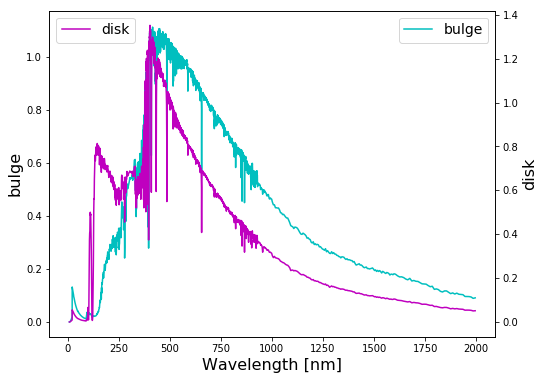

In [38]:
file,IDx,b_s,d_s = find_target_sed(gal_id=9688343588)

In [13]:
g_id

9438381284

In [28]:
file['disk_magnorm'][0][IDx],file['bulge_magnorm'][0][IDx]

(29.072571165669306, 28.782764654444097)

In [14]:
galaxy_ids = np.array([ 4813367392,  7875754559,  2562878640, 10688135419,  7251541884,
        9125114999,  8562957912,  4250372425,  6250534938,  3250450911,
        1688140822,  4125882008, 11938019038,  2813663888,  1375142352,
        5125197188, 11562875152,  2251155767,  1812742303,  2688381233,
        6062886029, 10939224906, 11438359281,  9500145936,  4437646567,
        3188247136,  5875651163, 11062617827,  1437690612])
for g_id in galaxy_ids:
    calc_colors(gal_id = g_id)
    print('--------------------------')

SED LookupFile:  sed_fit_9425.h5
SED template (bulge):  galaxySED/Inst.32E09.04Z.spec.gz
SED template (disk):  galaxySED/Exp.40E09.02Z.spec.gz
redshift:  0.6815274298511032
--------------------------
SED LookupFile:  sed_fit_9813.h5
SED template (bulge):  galaxySED/Burst.62E09.04Z.spec.gz
SED template (disk):  galaxySED/Burst.62E09.02Z.spec.gz
redshift:  0.6373819698913723
--------------------------
SED LookupFile:  sed_fit_9043.h5
SED template (bulge):  galaxySED/Burst.62E09.04Z.spec.gz
SED template (disk):  galaxySED/Const.12E10.02Z.spec.gz
redshift:  0.4708143717763775
--------------------------
SED LookupFile:  sed_fit_10201.h5
SED template (bulge):  galaxySED/Burst.62E09.04Z.spec.gz
SED template (disk):  galaxySED/Exp.62E09.04Z.spec.gz
redshift:  0.5933312677881073
--------------------------
SED LookupFile:  sed_fit_9690.h5
SED template (bulge):  galaxySED/Exp.62E09.002Z.spec.gz
SED template (disk):  galaxySED/Exp.40E08.1Z.spec.gz
redshift:  0.8477502395073966
--------------------

In [28]:
galaxy_ids = np.array([11688689226,  1437743580, 10313132699,  5125764534,  2313038358,
        2126755324,  1751006703, 10625438576,  8688261743, 11563376129,
        5937539934,  2937955908,  6250762091,  8187747632, 10687802491,
       10562504698,  1687797050,  3751370138,  8000650616,  2125141689,
        4125002175, 11313136616,  8687559910,  7938028488,  1625085001,
        3500040160,  4125530380,  7000380189,  5312686130,  2313368417])
for g_id in galaxy_ids:
    calc_colors(gal_id = g_id)
    print('--------------------------')

SED LookupFile:  sed_fit_10446.h5
SED template (bulge):  galaxySED/Exp.62E09.04Z.spec.gz
SED template (disk):  galaxySED/Exp.50E09.02Z.spec.gz
redshift:  0.7471837269088322
--------------------------
SED LookupFile:  sed_fit_8789.h5
SED template (bulge):  galaxySED/Inst.62E09.04Z.spec.gz
SED template (disk):  galaxySED/Exp.50E09.1Z.spec.gz
redshift:  0.42664270891084843
--------------------------
SED LookupFile:  sed_fit_10195.h5
SED template (bulge):  galaxySED/Burst.62E09.04Z.spec.gz
SED template (disk):  galaxySED/Exp.62E09.04Z.spec.gz
redshift:  0.6167931873020922
--------------------------
SED LookupFile:  sed_fit_9430.h5
SED template (bulge):  galaxySED/Exp.10E10.02Z.spec.gz
SED template (disk):  galaxySED/Exp.64E08.02Z.spec.gz
redshift:  0.6452306852060636
--------------------------
SED LookupFile:  sed_fit_8921.h5
SED template (bulge):  galaxySED/Burst.62E09.04Z.spec.gz
SED template (disk):  galaxySED/Const.20E09.02Z.spec.gz
redshift:  0.5475494988195901
-----------------------

SED LookupFile:  sed_fit_8786.h5
SED template (bulge):  galaxySED/Inst.62E09.04Z.spec.gz
SED template (disk):  galaxySED/Exp.16E09.02Z.spec.gz


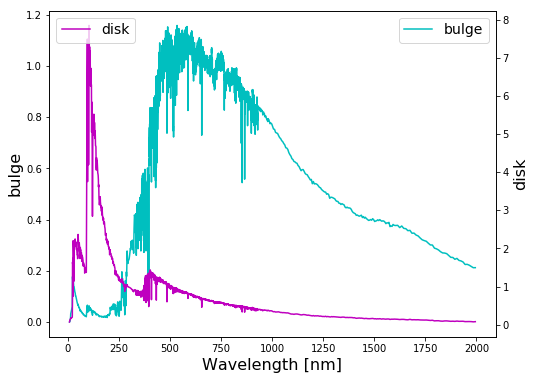

In [165]:
galaxy_id=1250374860
hfile,ID,bulge_s,disk_s = find_target_sed(gal_id=gal_id)